<h1 align="center" style="margin: 0; font-size: 36px;">Neural and Evolutionary Learning</h1>
<br>
<h1 align="center" style="margin: 0; font-size: 30px;">Project partial deliverable 3 (Slim GSGP)</h1>

<br>

**Group members:**<br>
Bárbara Capitão - 20211532@novaims.unl.pt <br>
Carolina Silvestre - 20211512@novaims.unl.pt <br>
Lara Leandro - 20211632@novaims.unl.pt <br>


### Requirements
-  Fit a SLIM-GSGP to the project dataset, including the hyperparameter tuning phase.
- Discuss the bloat, overfitting, and premature convergence on the algorithm.
- Include your own insights and summary conclusions.

### Table of Contents
[Imports](#chapter_1) <br>
[Settings](#chapter_2) <br>
[Load Data](#chapter_3) <br>
[Data Understanding](#chapter_4) <br>
[Data Preprocessing](#chapter_5) <br>
[Cross-Validation](#chapter_6) <br>
[Genetic Programming](#chapter_7) <br>
&nbsp;&nbsp;&nbsp;&nbsp;[Problem Instance Definition](#subchapter_7_1) <br>
&nbsp;&nbsp;&nbsp;&nbsp;[Solve](#subchapter_7_2) <br>
&nbsp;&nbsp;&nbsp;&nbsp;[Evolution Graphs](#subchapter_7_3) <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[Variation of RMSE across Models](#subchapter_7_3_1) <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[Train vs Test Fitness ](#subchapter_7_3_2) <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[Fitness vs Size Evolution](#subchapter__7_3_4) <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[Fitness Diversity](#s4bchapter_7_3_5) <br>
[To Evaluate](#chapter_8) <br>

<a id="chapter_1"></a>
## Imports


In [1]:
#! pip install slim_gsgp
#! pip install gplearn

In [2]:
import os
import random
import pickle
import datetime
from itertools import product
from collections import defaultdict

import numpy as np
import pandas as pd

import torch
from torch.utils.data import DataLoader, TensorDataset

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Scikit-learn 
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# Statistical tests
from scipy.stats import spearmanr, shapiro

# Symbolic regression 
from gplearn.genetic import SymbolicRegressor

# Custom modules
from slim_gsgp.datasets.data_loader import *
from slim_gsgp.main_slim import slim

import joblib


<a id="chapter_2"></a>
## Settings

In [3]:
seed = 43
np.random.seed(seed)

In [4]:
train_color = 'blue'
test_color = 'orange'
size_color = 'green'

<a id="chapter_3"></a>
## Load Data

In [5]:
# Load Excel file
df = pd.read_excel("sustavianfeed.xlsx")

In [6]:
df

WING TAG  WEIGHT  HOT CARCASS WEIGHT  CARCASS WEIGHT WITH HEAD AND LEGS  \
0      G403  2223.3              1429.6                             1725.6   
1      G439  2201.9              1450.2                             1769.8   
2      G454  2159.9              1398.4                             1724.9   
3      G465  2198.7              1473.9                             1800.4   
4      G428  2003.2              1291.2                             1581.6   
..      ...     ...                 ...                                ...   
91     V476  2633.1              1683.2                             2034.1   
92     V454  2346.2              1547.8                             1819.5   
93     V425  2648.2              1722.9                             2050.0   
94     V490  2262.6              1498.5                             1813.9   
95     V428  2704.3              1698.8                             2038.8   

    COLD CARCASS WEIGHT  BREAST WEIGHT (2)  THIGH WEIGHT (2)  SPLEEN   LIVER  \
0                1394.0              214.0             489.4   3.716  38.636   
1                1405.4              236.0             538.7   3.494  34.725   
2                1461.7              241.8             512.1   4.023  31.932   
3                1425.1              227.7             549.9   3.087  32.326   
4                1260.1              224.7             473.2   3.723  30.105   
..                  ...                ...               ...     ...     ...   
91               1637.2              213.8             610.9   4.777  45.992   
92               1511.2              228.0             528.2   3.673  35.090   
93               1669.8              253.1             610.0   5.176  50.505   
94               1468.0              212.1             548.4   2.829  30.266   
95               1655.6              245.7             606.9   5.960  40.922   

     HEART  INTESTINE EMPTY MUSCULAR STOMACH  GLANDULAR STOMACH  \
0    9.305    123.171                      /             13.170   
1   10.084     71.800                 45.273              9.781   
2   10.635     61.380                      /              6.217   
3   11.927     64.879                 35.861              8.358   
4    9.855     68.562                 36.526              7.572   
..     ...        ...                    ...                ...   
91  12.796     74.888                 54.021              7.857   
92  11.504     68.455                 42.173              7.837   
93  17.194     81.502                   49.7              7.332   
94  11.129     53.011                 46.816              5.425   
95  16.190     72.783                 75.767              7.420   

    CRUDE PROTEIN  ETHER EXTRACT  
0       86.105469           0.38  
1       86.143472           1.66  
2       86.416898           0.98  
3       85.959935           1.10  
4       81.693637           6.34  
..            ...            ...  
91      88.999126           1.07  
92      88.507288           1.13  
93      90.375587           1.91  
94      91.211353           2.21  
95      88.825045           1.51  

[96 rows x 15 columns]

In [7]:
# Droping ID column
df.drop(columns=['WING TAG'], inplace=True)

<a id="chapter_4"></a>
## Data Understanding

In [8]:
df.describe()

WEIGHT  HOT CARCASS WEIGHT  CARCASS WEIGHT WITH HEAD AND LEGS  \
count    96.000000           96.000000                          96.000000   
mean   2339.682292         1521.955208                        1833.378125   
std     200.943424          144.126939                         154.000550   
min    1968.400000         1284.900000                        1554.400000   
25%    2201.775000         1425.775000                        1723.800000   
50%    2299.500000         1493.050000                        1809.400000   
75%    2473.800000         1608.400000                        1922.725000   
max    2890.500000         1929.400000                        2262.800000   

       COLD CARCASS WEIGHT  BREAST WEIGHT (2)  THIGH WEIGHT (2)     SPLEEN  \
count            96.000000          96.000000         96.000000  96.000000   
mean           1481.479167         234.116667        542.205208   4.219917   
std             142.830115          37.818405         60.994468   0.998836   
min            1252.600000         177.100000        177.800000   2.464000   
25%            1380.825000         218.775000        508.225000   3.534250   
50%            1452.800000         231.550000        538.100000   4.048000   
75%            1573.700000         243.275000        573.850000   4.817000   
max            1891.700000         533.200000        690.600000   7.758000   

           LIVER      HEART   INTESTINE  GLANDULAR STOMACH  CRUDE PROTEIN  \
count  96.000000  96.000000   96.000000          96.000000      96.000000   
mean   36.781427  12.059240   69.149156           8.184677      87.313708   
std     5.438894   1.932239   11.727467           1.697425       2.043895   
min    25.916000   8.561000   44.133000           5.425000      73.837184   
25%    33.053000  10.584250   62.274250           7.012750      86.544416   
50%    35.936000  11.679000   68.019500           7.809500      87.574947   
75%    40.485000  13.449750   75.103000           9.016750      88.508026   
max    53.133000  17.194000  123.171000          13.170000      91.211353   

       ETHER EXTRACT  
count      96.000000  
mean        2.090417  
std         1.351645  
min         0.320000  
25%         1.130000  
50%         1.710000  
75%         2.527500  
max         6.680000

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   WEIGHT                             96 non-null     float64
 1   HOT CARCASS WEIGHT                 96 non-null     float64
 2   CARCASS WEIGHT WITH HEAD AND LEGS  96 non-null     float64
 3   COLD CARCASS WEIGHT                96 non-null     float64
 4   BREAST WEIGHT (2)                  96 non-null     float64
 5   THIGH WEIGHT (2)                   96 non-null     float64
 6   SPLEEN                             96 non-null     float64
 7   LIVER                              96 non-null     float64
 8   HEART                              96 non-null     float64
 9   INTESTINE                          96 non-null     float64
 10  EMPTY MUSCULAR STOMACH             96 non-null     object 
 11  GLANDULAR STOMACH                  96 non-null     float64
 

> The column 'EMPTY MUSCULAR STOMACH' has been read as type object, possibly because some entries contain non-numeric or unexpected values, preventing it from being interpreted as float

In [10]:
df['EMPTY MUSCULAR STOMACH'].value_counts()

EMPTY MUSCULAR STOMACH
/         5
75.767    2
47.964    1
51.322    1
59.583    1
         ..
63.571    1
49.648    1
43.586    1
53.456    1
46.816    1
Name: count, Length: 91, dtype: int64

> The 'EMPTY MUSCULAR STOMACH' as 5 values '/'

In [11]:
# Coverting the column to numeric, forcing '/' to became Nan
df['EMPTY MUSCULAR STOMACH'] = pd.to_numeric(df['EMPTY MUSCULAR STOMACH'], errors='coerce')

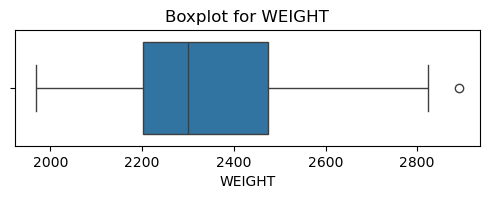

WEIGHT — Outliers detected: 1


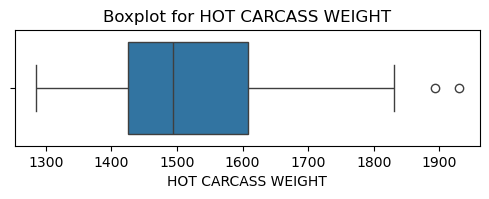

HOT CARCASS WEIGHT — Outliers detected: 2


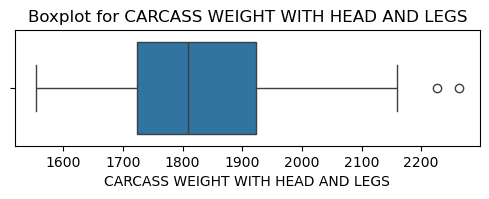

CARCASS WEIGHT WITH HEAD AND LEGS — Outliers detected: 2


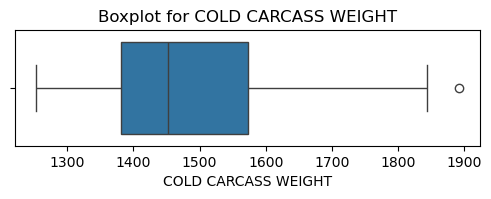

COLD CARCASS WEIGHT — Outliers detected: 1


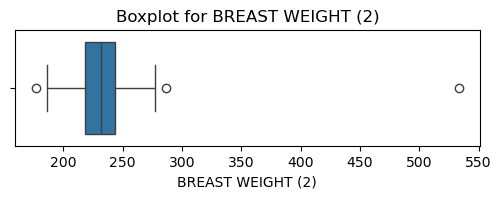

BREAST WEIGHT (2) — Outliers detected: 3


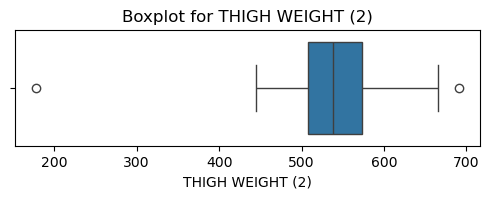

THIGH WEIGHT (2) — Outliers detected: 2


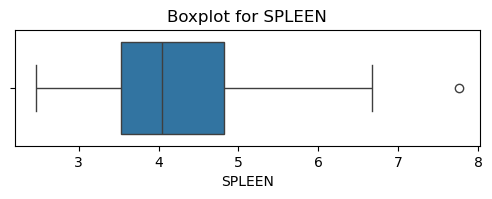

SPLEEN — Outliers detected: 1


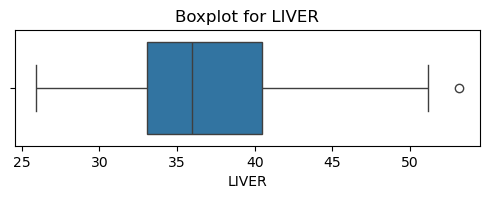

LIVER — Outliers detected: 1


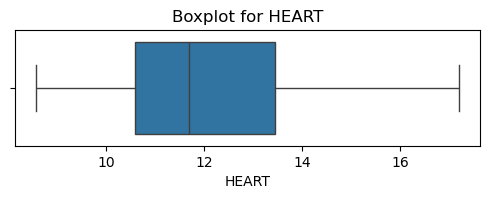

HEART — Outliers detected: 0


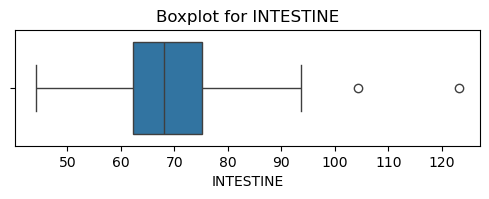

INTESTINE — Outliers detected: 2


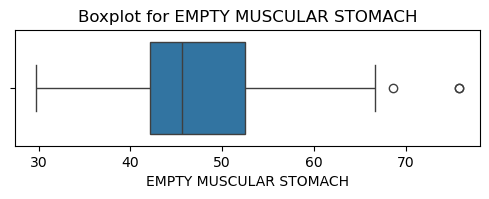

EMPTY MUSCULAR STOMACH — Outliers detected: 3


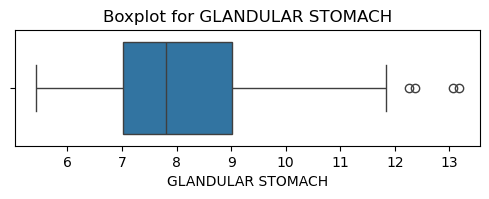

GLANDULAR STOMACH — Outliers detected: 4


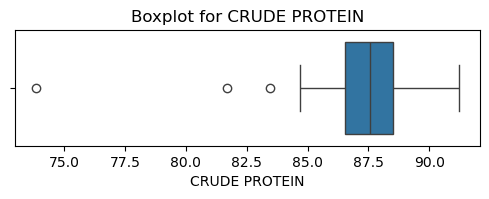

CRUDE PROTEIN — Outliers detected: 3


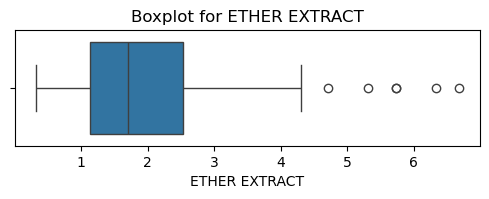

ETHER EXTRACT — Outliers detected: 6


In [12]:
def detect_outliers_iqr(df):
    outlier_info = {}

    for col in df.select_dtypes(include = [np.number] ).columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Geting the outliers
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
        outlier_info[col] = {
            'count': outliers.count(),
            'outliers': outliers.values
        }

        # Ploting the boxplots
        plt.figure(figsize=(6, 1.5))
        sns.boxplot(x=df[col], orient='h' )
        plt.title(f"Boxplot for {col}")
        plt.show()

        print(f"{col} — Outliers detected: {outliers.count()}")
    
    return outlier_info

outlier_summary = detect_outliers_iqr(df)

Most columns contain some outliers, but they are few in number and not particularly extreme, so we’ve decided to keep them.
The most notable outliers appear in:

- Breast weight: typically ranges from 200–250, but one value is around 550.

- Thigh weight: usually between 450–650, but there's one outlier close to 200.

- Crude protein: generally falls between 85–95, but there's a value near 72.5.


 Analyzing column: WEIGHT


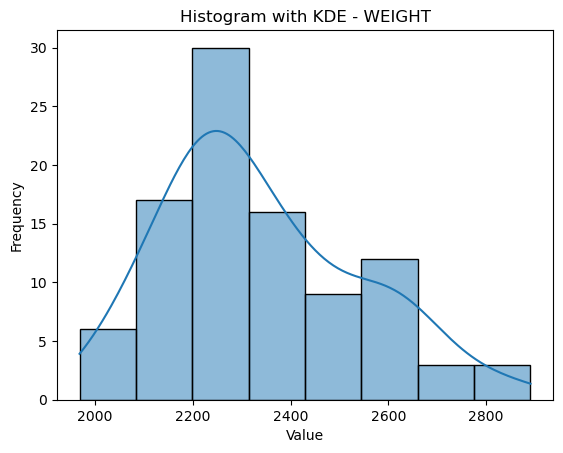

Shapiro-Wilk Test statistic = 0.9641, p-value = 0.0100
 Not normally distributed (reject H0)

 Analyzing column: HOT CARCASS WEIGHT


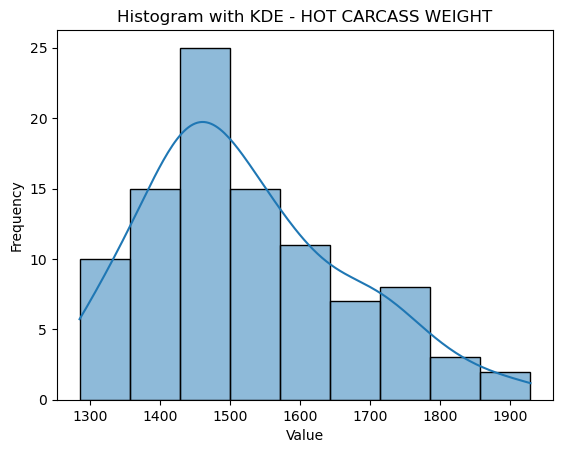

Shapiro-Wilk Test statistic = 0.9611, p-value = 0.0061
 Not normally distributed (reject H0)

 Analyzing column: CARCASS WEIGHT WITH HEAD AND LEGS


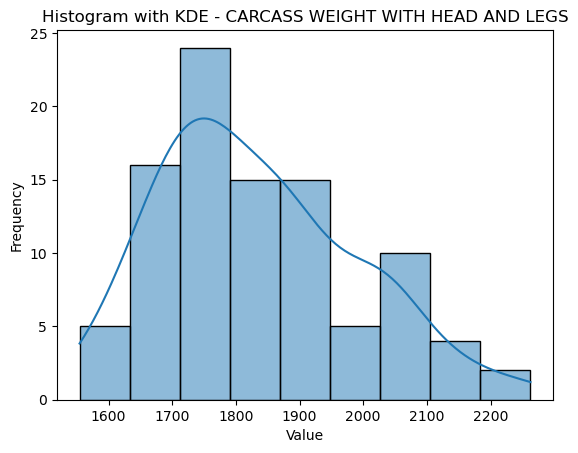

Shapiro-Wilk Test statistic = 0.9641, p-value = 0.0099
 Not normally distributed (reject H0)

 Analyzing column: COLD CARCASS WEIGHT


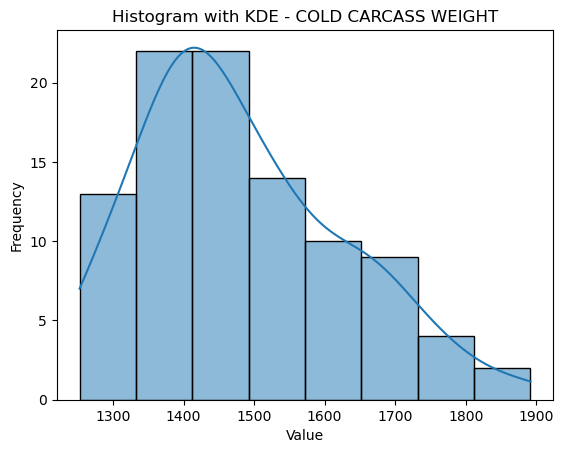

Shapiro-Wilk Test statistic = 0.9577, p-value = 0.0036
 Not normally distributed (reject H0)

 Analyzing column: BREAST WEIGHT (2)


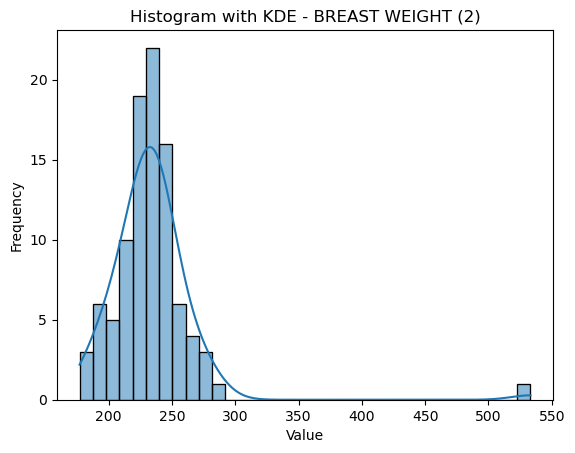

Shapiro-Wilk Test statistic = 0.6057, p-value = 0.0000
 Not normally distributed (reject H0)

 Analyzing column: THIGH WEIGHT (2)


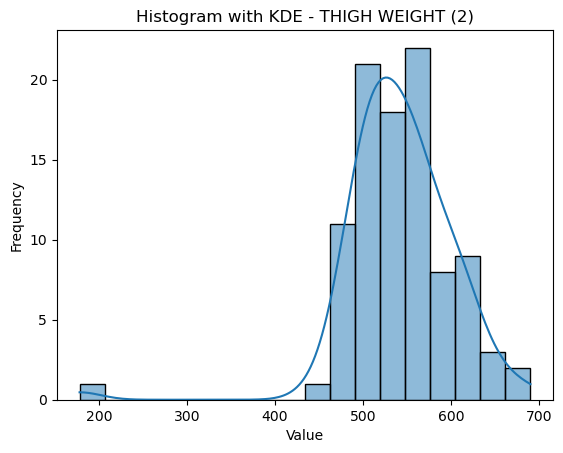

Shapiro-Wilk Test statistic = 0.8492, p-value = 0.0000
 Not normally distributed (reject H0)

 Analyzing column: SPLEEN


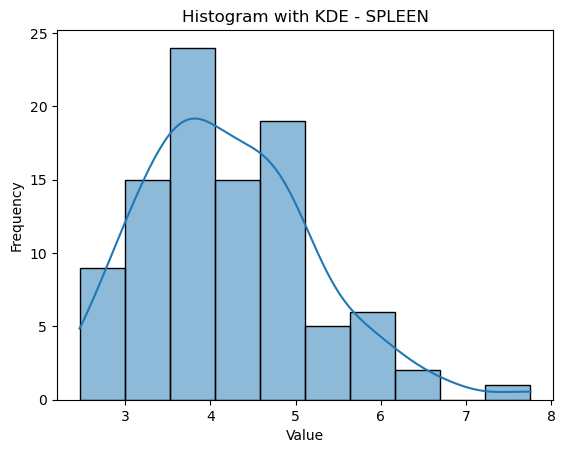

Shapiro-Wilk Test statistic = 0.9657, p-value = 0.0129
 Not normally distributed (reject H0)

 Analyzing column: LIVER


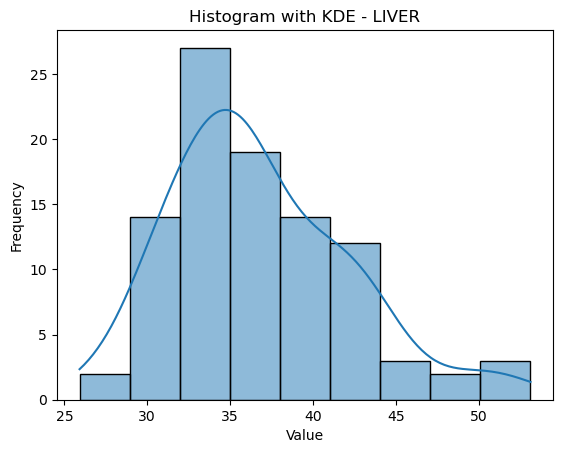

Shapiro-Wilk Test statistic = 0.9633, p-value = 0.0086
 Not normally distributed (reject H0)

 Analyzing column: HEART


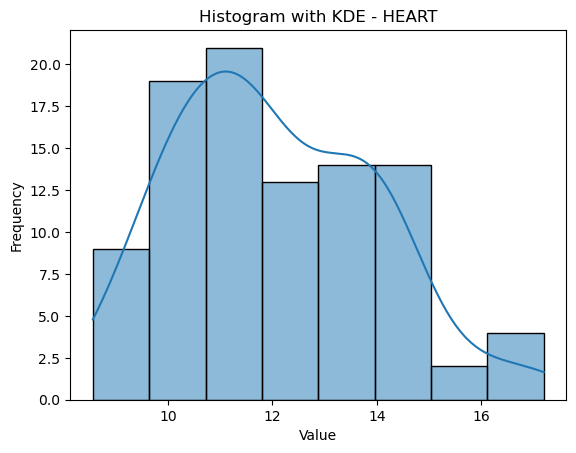

Shapiro-Wilk Test statistic = 0.9730, p-value = 0.0443
 Not normally distributed (reject H0)

 Analyzing column: INTESTINE


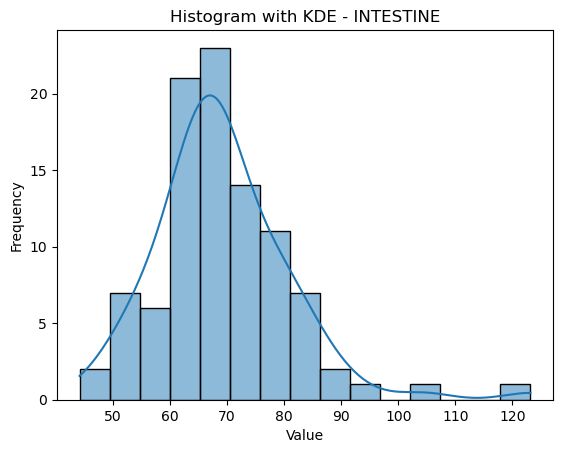

Shapiro-Wilk Test statistic = 0.9302, p-value = 0.0001
 Not normally distributed (reject H0)

 Analyzing column: EMPTY MUSCULAR STOMACH


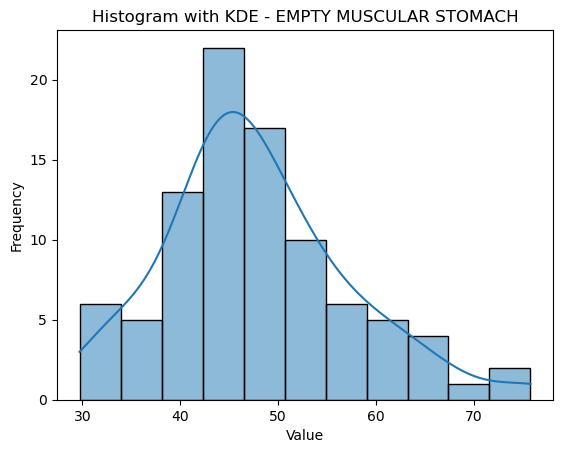

Shapiro-Wilk Test statistic = 0.9656, p-value = 0.0167
 Not normally distributed (reject H0)

 Analyzing column: GLANDULAR STOMACH


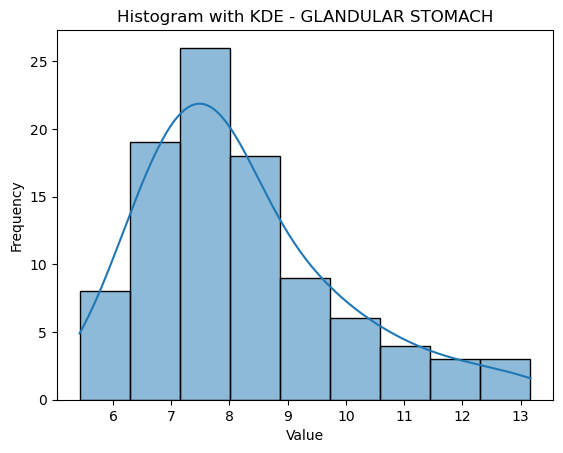

Shapiro-Wilk Test statistic = 0.9303, p-value = 0.0001
 Not normally distributed (reject H0)

 Analyzing column: CRUDE PROTEIN


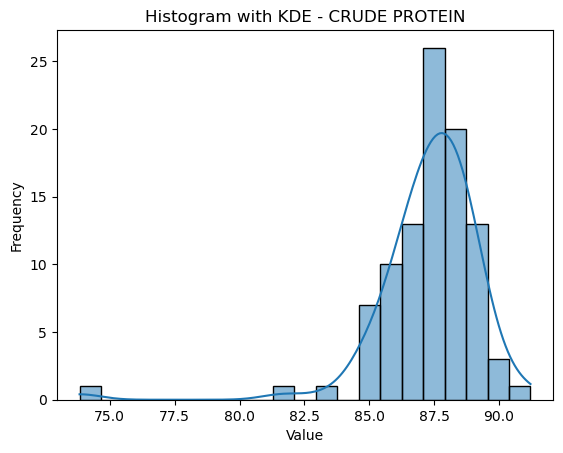

Shapiro-Wilk Test statistic = 0.7674, p-value = 0.0000
 Not normally distributed (reject H0)

 Analyzing column: ETHER EXTRACT


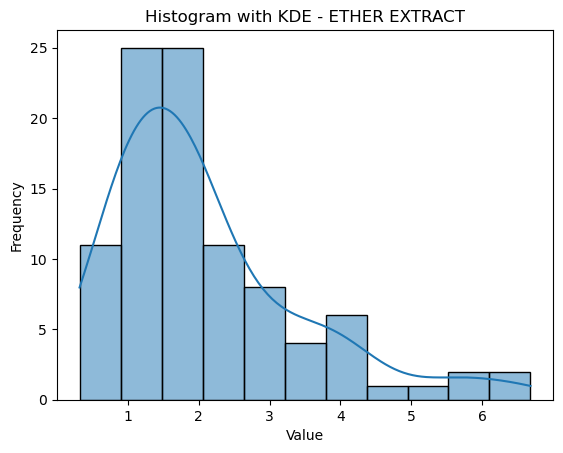

Shapiro-Wilk Test statistic = 0.8674, p-value = 0.0000
 Not normally distributed (reject H0)


In [13]:
# Checking if the data is normally distributed

for column in df.select_dtypes(include=[np.number]).columns:
    print(f"\n Analyzing column: {column}")
    data = df[column].dropna()  

    # Histogram + KDE
    sns.histplot(data, kde=True)
    plt.title(f"Histogram with KDE - {column}")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.show()


    # Shapiro-Wilk Test
    stat, p = shapiro(data)
    print(f"Shapiro-Wilk Test statistic = {stat:.4f}, p-value = {p:.4f}")
    if p > 0.05:
        print(" Likely normal (fail to reject H0)")
    else:
        print(" Not normally distributed (reject H0)")


> All columns in the dataset exhibit non-normal distributions, as confirmed by visual inspection and statistical tests 

<a id="chapter_5"></a>
## Data Preprocessing

In [14]:
# Missing Values
# Calculating the mean
mean_value = df['EMPTY MUSCULAR STOMACH'].mean()

# Replacing the NaNs with the mean
df['EMPTY MUSCULAR STOMACH'] = df['EMPTY MUSCULAR STOMACH'].fillna(mean_value)


In [15]:
# Separating the features from the target
features = df.drop(columns=['CRUDE PROTEIN'])
target = df['CRUDE PROTEIN']

# Scaling the features
scaler = RobustScaler() # since the data is not normally distributed and contains outliers, we opted to use the RobustScaler
X_scaled = scaler.fit_transform(features)


X = torch.tensor(X_scaled, dtype=torch.float32)
y = torch.tensor(target.values, dtype=torch.float32)

<a id="chapter_6"></a>
## Cross-Validation

In [59]:
# Nested Cross Validation
k_outer = 5
k_inner = 3
cv_outer = KFold(n_splits=k_outer, random_state=seed, shuffle=True)
cv_inner = KFold(n_splits=k_inner, random_state=seed, shuffle=True)

We opted to use **nested cross-validation** instead of Monte Carlo because it gives a more confident and reliable estimate of how well the model will perform on new data. The **outer loop** is used to test the model, while the **inner loop** is used for hyperparameter tuning. This setup helps avoid overfitting during tuning and gives a more honest evaluation of the model’s generalization performance.

We chose **5 outer folds** because it gives a good balance between reliable performance estimates and computation time. For the **inner loop**, we used **3 folds** to keep hyperparameter tuning efficient without sacrificing too much accuracy..


<a id="chapter_7"></a>
## Genetic Programming

<a id="subchapter_7_1"></a>
### Problem Instance Definition 

In [17]:
DATASET_NAME = 'Sustavian'
FITNESS_FUNCTION = 'rmse'
MINIMIZATION = True

total_instances = X.shape[0]
outer_test_size = total_instances // k_outer
outer_train_size = total_instances - outer_test_size
inner_val_size = outer_train_size // k_inner
inner_train_size = outer_train_size - inner_val_size

print(f'Total Instances:\t{total_instances}\n--')
print(f'Outer Train set:\t{outer_train_size}')
print(f'Test set:\t\t{outer_test_size}\n--')
print(f'Inner Train set:\t{inner_train_size}')
print(f'Validation set:\t\t{inner_val_size}\n')

Total Instances:	96
--
Outer Train set:	77
Test set:		19
--
Inner Train set:	52
Validation set:		25



<a id="subchapter_7_2"></a>
### Solve 

In [18]:
LOG_DIR = './log/NEL_project/'
LOG_PATH = LOG_DIR + f'slim_1_{DATASET_NAME}.csv'
os.makedirs(LOG_DIR, exist_ok=True)
if os.path.exists(LOG_PATH):
    os.remove(LOG_PATH)

In [19]:
TREE_CONSTANTS = [random.uniform(0, 1) for _ in range(9)] + [-1.]
TREE_FUNCTIONS = ['add', 'subtract', 'multiply', 'divide']
PROB_CONSTANT = 0.1
MAX_INIT_DEPTH = 4

<p align="left" style="margin: 5; font-size: 20px; font-weight: bold;">Common Problems in GSGP</p>

**Overfitting:**  
Model fits training data too closely and fails to generalize to new data.

**Bloat:**  
Excessive growth of tree size without fitness improvement, making models unnecessarily complex.

**Premature Convergence:**  
Population loses diversity too early and gets stuck in suboptimal solutions.



<p align="left" style="margin: 5; font-size: 20px; font-weight: bold;">Parameters that influence each problem:</p>

- **Overfitting:**  
  - `max_depth`: deeper trees can capture noise -> overfit  
  - `n_elites`: too many elites reduce exploration -> overfit  
  - `p_xo` (crossover rate): low rates limit diversity - overfit  
  - `initializer`: affects initial tree complexity

<p align="left" style="margin: 0; font-size: 10px;"> </p>

- **Bloat:**  
  - `max_depth`: limits max tree size  
  - `initializer`: e.g. 'grow' creates larger initial trees  
  - `n_elites`: preserves large individuals longer -> bloat  

<h1 align="left" style="margin: 0; font-size: 10px;"> </h1>

- **Premature Convergence:**  
  - `p_xo`: higher crossover keeps diversity  
  - `initializer`: influences initial population diversity  
  - `n_elites`: high elitism reduces diversity too fast  
  - `tournament_size`: bigger tournaments increase selection pressure -> less diversity
 


SLIM-GSGP is used because it is specifically designed to reduce bloat, one of the major challenges in standard GSGP. Therefore, our grid search focuses on evaluating its different variants to better understand their behavior and effectiveness.



In [60]:
POP_SIZE = 200
SLIM_VERSIONS = ['SLIM+SIG2', 'SLIM+SIG1', 'SLIM+ABS','SLIM*SIG2', 'SLIM*SIG1', 'SLIM*ABS']

#Fixed Parameters

fixed_params = {
    # Search Space
    "initializer": 'rhh',
    "init_depth": MAX_INIT_DEPTH,
    "max_depth":15,
    "tree_constants": TREE_CONSTANTS,
    "tree_functions": TREE_FUNCTIONS,
    "prob_const": PROB_CONSTANT,
    
    # Problem Instance
  
    "dataset_name": DATASET_NAME,
    "fitness_function": FITNESS_FUNCTION,
    "minimization": MINIMIZATION,

    # Solve settings
    "elitism": True,
    "n_iter": 150,
    "n_elites": 3,
    "test_elite": True,
    "log_path": LOG_PATH,
    "log_level": 2,
    "verbose": 1,
    "n_jobs": 1,
    "seed": seed,
    
    # SLIM-GSGP Instance
    "tournament_size": 2,
    "pop_size": POP_SIZE,
    "ms_lower": 0,
    "ms_upper": 1,
    "p_inflate": 0.3, 
    "copy_parent": False, # early tests 
    "reconstruct": True,


}

# Parameters Grid Search

param_grid = {
    
    "slim_version": SLIM_VERSIONS,
    
   # "p_inflate": [0.9, 0.3, 0.05],

    # Search Space
    #"max_depth": [10, 20],

    # Solve settings
  #  "n_elites": [1, 3]
}


> Initial tests revealed a lack of population diversity, so we tried to adjust key parameters: we increased "p_inflate" from 0.05 to 0.3, set "copy_parent" to False, and raised the number of iterations. It helped improve especially semantic diversity, however the final performances were relatively  similar

In [61]:
def call_slim(fixed_params, param_grid, seed, set_max_depth = False):
    models = []
    keys, values = zip(*param_grid.items())
    for combo in product(*values):
        dynamic_params = dict(zip(keys, combo))
        full_params = {**fixed_params, **dynamic_params}
        if set_max_depth:
            full_params.update({'max_depth': full_params['init_depth']+15})
        model = slim(**full_params)
        res = {'model': model}
        res.update({'rmse_train': model.fitness.item()})
        res.update({'rmse_test': model.test_fitness.item()})
        res.update({'dynamic_params': dynamic_params})
        models.append(res)
    return models      


In [62]:
all_results = []  # Store results for each outer fold

# Outer CV loop
for i_outer, (learning_ix, test_ix) in enumerate(cv_outer.split(X, y)):
    X_learning, y_learning = X[learning_ix], y[learning_ix]
    X_test, y_test = X[test_ix], y[test_ix]

    print('\n' + '-' * 41 + '\n')
    print(f'Outer CV {i_outer}\nLearning shape: {X_learning.shape}\nTest shape: {X_test.shape}\n')
    
    # Inner CV loop
    inner_results = []
    for i_inner, (train_ix, val_ix) in enumerate(cv_inner.split(X_learning, y_learning)):
        print('-----\nInner CV {}'.format(i_inner))
        
        X_train, y_train = X_learning[train_ix], y_learning[train_ix]
        X_val, y_val = X_learning[val_ix], y_learning[val_ix]

        print(f'Training shape: {X_train.shape}\nValidation shape: {X_val.shape}\n')
        
        fixed_params.update({
            'X_train': X_train,
            'y_train': y_train,
            'X_test': X_val,
            'y_test': y_val,
        })

        # Unique log path for each outer+inner
        LOG_PATH = os.path.join(LOG_DIR, f'slim_1_{DATASET_NAME}_outer{i_outer}_inner{i_inner}.csv')
        if os.path.exists(LOG_PATH):
            os.remove(LOG_PATH)
        fixed_params.update({'log_path': LOG_PATH})

        # Run model
        res = call_slim(fixed_params, param_grid, seed=(seed + i_outer * 100 + i_inner))

        # Save result of this inner fold
        inner_results.append(res)

    # Save inner results from this outer fold
    all_results.append({
        'outer_fold': i_outer,
        'test_ix': test_ix,
        'results': inner_results
    })



-----------------------------------------

Outer CV 0
Learning shape: torch.Size([76, 13])
Test shape: torch.Size([20, 13])

-----
Inner CV 0
Training shape: torch.Size([50, 13])
Validation shape: torch.Size([26, 13])

Verbose Reporter
-----------------------------------------------------------------------------------------------------------------------------------------
|         Dataset         |  Generation  |     Train Fitness     |       Test Fitness       |        Timing          |      Nodes       |
-----------------------------------------------------------------------------------------------------------------------------------------
|     Sustavian           |       0      |   85.7002944946289    |   85.992919921875        |   1.2925524711608887   |      3           |
|     Sustavian           |       1      |   85.54505157470703   |   85.91320037841797      |   0.449796199798584    |      14          |
|     Sustavian           |       2      |   85.49739837646484   |   85.6

In [63]:
all_results

[{'outer_fold': 0,
  'test_ix': array([ 0,  1,  2,  5,  9, 11, 13, 15, 20, 22, 38, 55, 56, 57, 62, 67, 76,
         82, 84, 85]),
  'results': [[{'model': <slim_gsgp.algorithms.SLIM_GSGP.representations.individual.Individual at 0x2375e694da0>,
     'rmse_train': 83.35012817382812,
     'rmse_test': 83.78829956054688,
     'dynamic_params': {'slim_version': 'SLIM+SIG2'}},
    {'model': <slim_gsgp.algorithms.SLIM_GSGP.representations.individual.Individual at 0x237612faf00>,
     'rmse_train': 81.78511810302734,
     'rmse_test': 81.79859161376953,
     'dynamic_params': {'slim_version': 'SLIM+SIG1'}},
    {'model': <slim_gsgp.algorithms.SLIM_GSGP.representations.individual.Individual at 0x2375e695040>,
     'rmse_train': 82.73829650878906,
     'rmse_test': 82.98479461669922,
     'dynamic_params': {'slim_version': 'SLIM+ABS'}},
    {'model': <slim_gsgp.algorithms.SLIM_GSGP.representations.individual.Individual at 0x2375e690590>,
     'rmse_train': 76.46701049804688,
     'rmse_test': 79

<a id="subchapter_7_3"></a>
### Evolution Graphs

In [64]:
pd.read_csv(LOG_PATH, header=None)

0                                     1          2   3    4   \
0    SLIM+SIG2  f92616df-36ff-11f0-87d4-00f48dd34ab0  Sustavian  43    0   
1    SLIM+SIG2  f92616df-36ff-11f0-87d4-00f48dd34ab0  Sustavian  43    1   
2    SLIM+SIG2  f92616df-36ff-11f0-87d4-00f48dd34ab0  Sustavian  43    2   
3    SLIM+SIG2  f92616df-36ff-11f0-87d4-00f48dd34ab0  Sustavian  43    3   
4    SLIM+SIG2  f92616df-36ff-11f0-87d4-00f48dd34ab0  Sustavian  43    4   
..         ...                                   ...        ...  ..  ...   
901   SLIM*ABS  f92616df-36ff-11f0-87d4-00f48dd34ab0  Sustavian  43  146   
902   SLIM*ABS  f92616df-36ff-11f0-87d4-00f48dd34ab0  Sustavian  43  147   
903   SLIM*ABS  f92616df-36ff-11f0-87d4-00f48dd34ab0  Sustavian  43  148   
904   SLIM*ABS  f92616df-36ff-11f0-87d4-00f48dd34ab0  Sustavian  43  149   
905   SLIM*ABS  f92616df-36ff-11f0-87d4-00f48dd34ab0  Sustavian  43  150   

            5         6        7          8    9           10          11  12  
0    84.696930  0.215452   1156.0  86.152473   15  195.679092  117.438700   2  
1    84.696930  0.503721   3531.0  86.152473   15   28.525953    0.649921   2  
2    84.696930  0.274301   2757.0  86.152473   15   37.902233    0.627767   2  
3    84.696930  0.422923   4484.0  86.152473   15   56.222649    0.646161   2  
4    84.696152  0.259337   3704.0  86.160339   43   63.924786    0.533582   2  
..         ...       ...      ...        ...  ...         ...         ...  ..  
901  77.153664  0.320185  16601.0  92.568459  117   91.234940    1.833565   2  
902  76.895576  0.205476  17542.0  98.679634  121   92.798767    1.920872   2  
903  76.895576  0.235403  17715.0  98.679634  121   87.734528    1.869161   2  
904  76.895576  0.223433  17239.0  98.679634  121   87.606697    1.845175   2  
905  76.895576  0.279289  16672.0  98.679634  121   84.835464    1.747120   2  

[906 rows x 13 columns]

<a id="subchapter_7_3_1"></a>
#### Variation of RMSE across Models

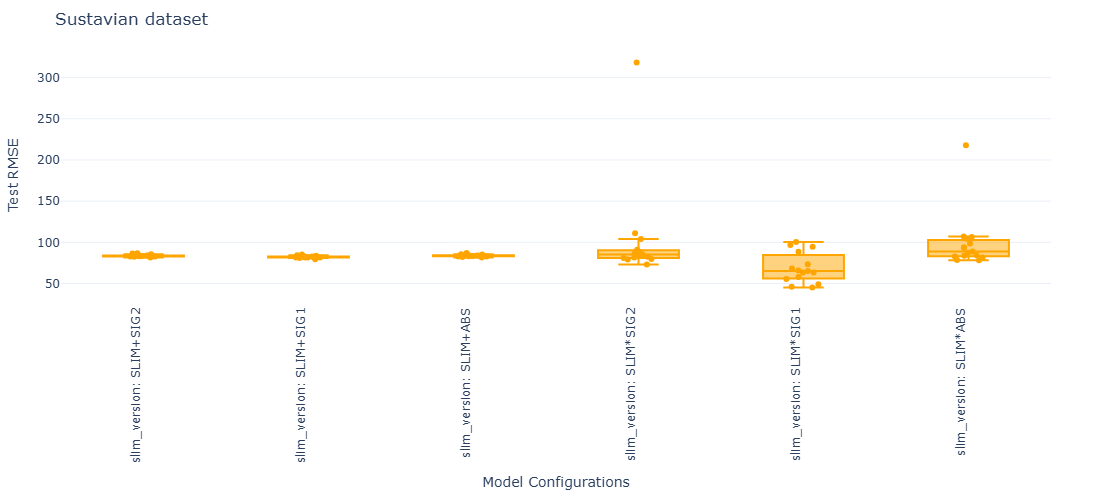

In [65]:
# Boxplots for comparison of Test RMSE Distributions across Model 

rmse_by_config = defaultdict(list)

# Loop through each outer fold
for outer in all_results:
    # outer['results'] is a list of lists of result dicts
    for inner_results in outer['results']:
        for result in inner_results:
            if not isinstance(result, dict):
                continue  

            # Generate key based on dynamic parameters
            key = ''
            for k, v in result.get('dynamic_params', {}).items():
                key += f"{k}: {v} <br /> "
            
            rmse_by_config[key].append(result['rmse_test'])

# Build boxplot
fig = go.Figure()
for config, rmse_values in rmse_by_config.items():
    fig.add_trace(go.Box(
        y=rmse_values,
        boxpoints='all',
        jitter=0.5,
        pointpos=0,
        line=dict(color='orange'),
        name=config
    ))

fig.update_layout(
    title=DATASET_NAME + ' dataset',
    xaxis_title='Model Configurations',
    yaxis_title='Test RMSE',
    height=500,
    width=1100,
    xaxis_tickangle=-90,
    yaxis_range=[0, None],
    margin=dict(l=50, r=50, t=50, b=20),
    showlegend=False,
    template='plotly_white'
)

fig.show()




Overall, the test RMSE ranges from 45 to 318, which is considerably higher than the values observed with GP and GSGP. The SLIM+ variants produce more stable results, but their performance is consistently poor, with RMSE values ranging between 80 and 90. In contrast, the SLIM* variants exhibit greater variability, yet tend to perform better overall, especially SLIM*SIG1, which achieves a median test RMSE of 65.

In [66]:
df_log = []

for outer_ix in range(k_outer):  # loop over outer folds
    for inner_ix in range(k_inner):  # loop over inner folds
        log_path = os.path.join(LOG_DIR, f'slim_{DATASET_NAME}_outer{outer_ix}_inner{inner_ix}.csv')
        
        if os.path.exists(log_path):  # check to avoid errors
            tmp = pd.read_csv(log_path, header=None)
            tmp['outer'] = outer_ix
            tmp['inner'] = inner_ix
            df_log.append(tmp)

df_log = pd.concat(df_log, ignore_index=True)


In [67]:
df_log.columns = ['params', 'instance_id', 'dataset', 'seed', 'generation', 'rmse_train', 'run_time', 'pop_nodes', 
                  'rmse_test', 'number_nodes', 'genotype_div', 'fitness_std', 'log_level', 'cv_outer', 'cv_inner']

In [68]:
# Log level 2
# -----------
# 0  - Algorithm
# 1  - Instance ID
# 2  - Dataset
# 3  - Seed
# 4  - Generation
# 5  - Fitness
# 6  - Running time
# 7  - Population nodes
# 8  - Test fitness
# 9  - Elite nodes
# 10 - Genotype diversity: gsgp_pop_div_from_vectors (Calculate the diversity of a population from semantic vectors)
# 11 - Phenotype diversity: sd(pop.fit)
# 12 - Log level
# 13 - CV Outer
# 14 - CV Inner

In [69]:
df_log

params                           instance_id    dataset  seed  \
0      SLIM+SIG2  c8148058-36f6-11f0-8f88-00f48dd34ab0  Sustavian    43   
1      SLIM+SIG2  c8148058-36f6-11f0-8f88-00f48dd34ab0  Sustavian    43   
2      SLIM+SIG2  c8148058-36f6-11f0-8f88-00f48dd34ab0  Sustavian    43   
3      SLIM+SIG2  c8148058-36f6-11f0-8f88-00f48dd34ab0  Sustavian    43   
4      SLIM+SIG2  c8148058-36f6-11f0-8f88-00f48dd34ab0  Sustavian    43   
...          ...                                   ...        ...   ...   
13585   SLIM*ABS  c8148058-36f6-11f0-8f88-00f48dd34ab0  Sustavian    43   
13586   SLIM*ABS  c8148058-36f6-11f0-8f88-00f48dd34ab0  Sustavian    43   
13587   SLIM*ABS  c8148058-36f6-11f0-8f88-00f48dd34ab0  Sustavian    43   
13588   SLIM*ABS  c8148058-36f6-11f0-8f88-00f48dd34ab0  Sustavian    43   
13589   SLIM*ABS  c8148058-36f6-11f0-8f88-00f48dd34ab0  Sustavian    43   

       generation  rmse_train  run_time  pop_nodes  rmse_test  number_nodes  \
0               0   85.244385  0.321744     1156.0  84.624779             5   
1               1   85.244385  0.121378     1232.0  84.624779             5   
2               2   85.244385  0.129868     1124.0  84.624779             5   
3               3   85.244385  0.121880      876.0  84.624779             5   
4               4   85.244385  0.093877      948.0  84.624779             5   
...           ...         ...       ...        ...        ...           ...   
13585         146   79.177773  0.196203     7804.0  88.304031            73   
13586         147   79.177773  0.176460     8137.0  88.304031            73   
13587         148   79.080811  0.179403     8251.0  87.858780            99   
13588         149   79.080811  0.161536     8679.0  87.858780            99   
13589         150   79.080811  0.148915     8788.0  87.858780            99   

       genotype_div  fitness_std  log_level  cv_outer  cv_inner  
0        229.374878   121.873350          2         0         0  
1         26.679937     0.457028          2         0         0  
2         37.021244     0.422261          2         0         0  
3         35.574280     0.477076          2         0         0  
4         18.158215     0.487466          2         0         0  
...             ...          ...        ...       ...       ...  
13585     47.852867     1.084435          2         4         2  
13586     43.252594     0.870729          2         4         2  
13587     45.759686     0.959328          2         4         2  
13588     44.834839     1.003503          2         4         2  
13589     43.032993     0.933000          2         4         2  

[13590 rows x 15 columns]

<a id="subchapter_7_3_2"></a>
#### Train vs Test Fitness 

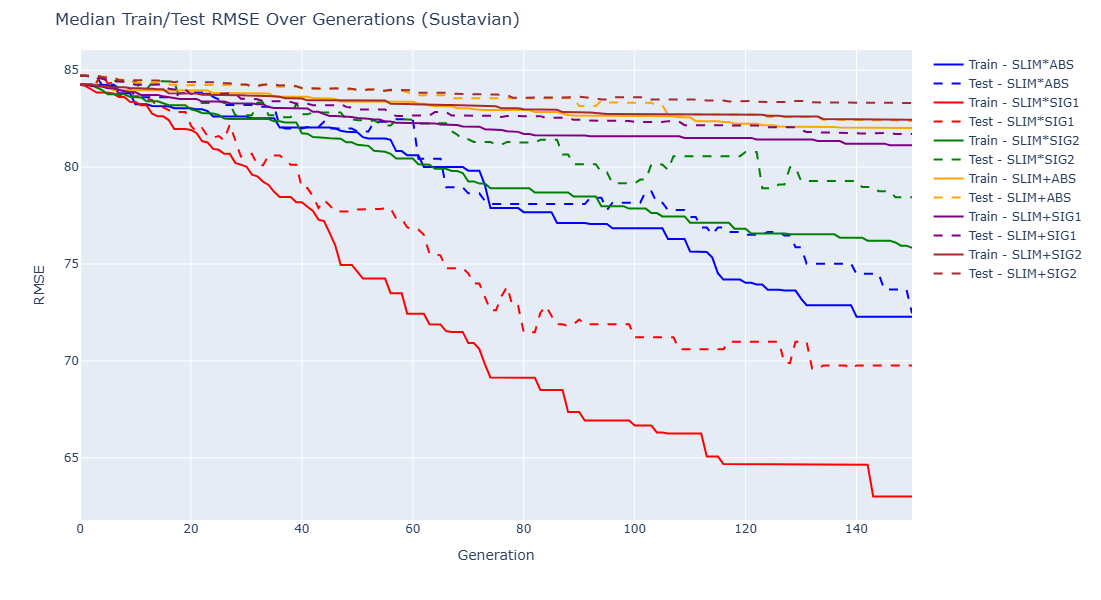

In [70]:
# Group by parameter combo and generation, then calculate median RMSE
median_rmse = df_log.groupby(['params', 'generation'])[['rmse_train', 'rmse_test']].median().reset_index()


fig = go.Figure()
colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']

for i, (param_key, group) in enumerate(median_rmse.groupby('params')):
    color = colors[i % len(colors)]
    
    # Median Train RMSE over generations
    fig.add_trace(go.Scatter(
        x=group['generation'],
        y=group['rmse_train'],
        mode='lines',
        name=f'Train - {param_key}',
        line=dict(color=color, dash='solid')
    ))
    
    # Median Test RMSE over generations
    fig.add_trace(go.Scatter(
        x=group['generation'],
        y=group['rmse_test'],
        mode='lines',
        name=f'Test - {param_key}',
        line=dict(color=color, dash='dash')
    ))

fig.update_layout(
    title=f'Median Train/Test RMSE Over Generations ({DATASET_NAME})',
    xaxis_title='Generation',
    yaxis_title='RMSE',
    height=600, width=1000,
    margin=dict(t=50),
)

fig.show()

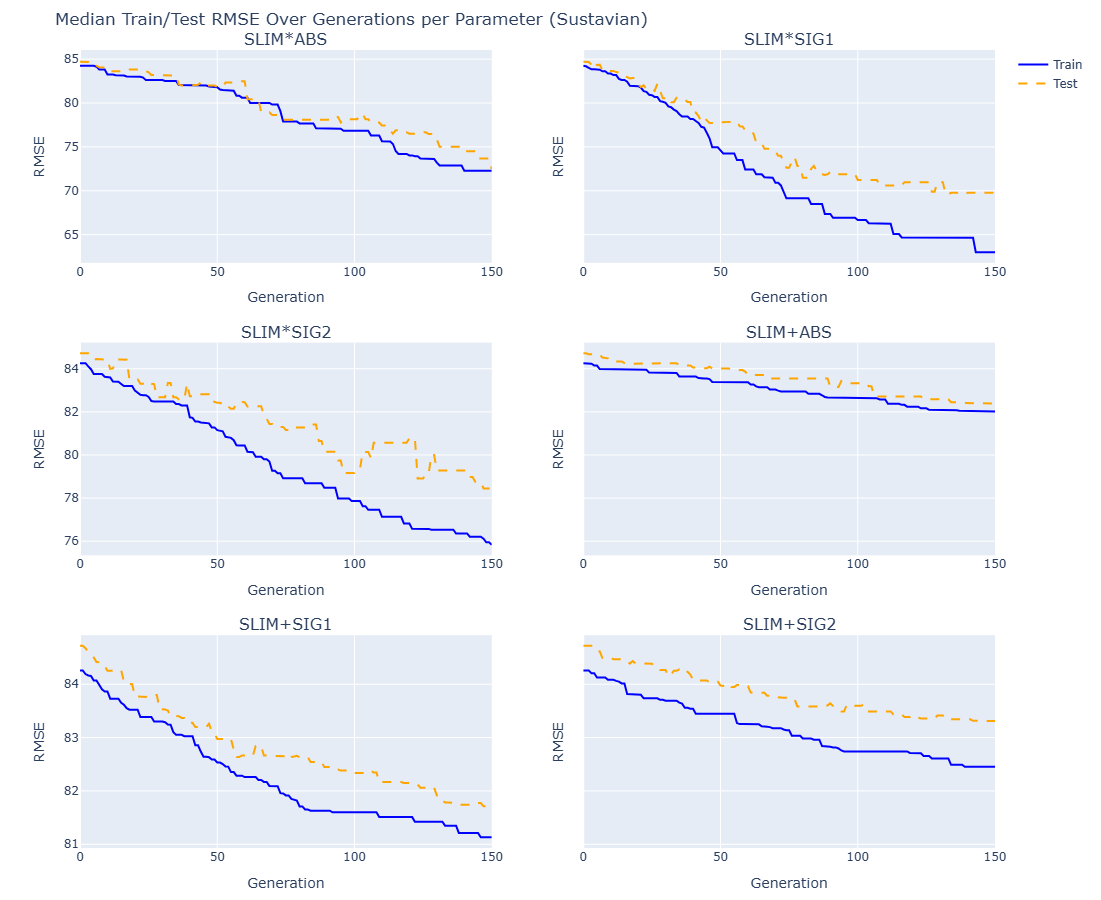

In [71]:
# Get unique parameter sets
param_sets = median_rmse['params'].unique()
n_params = len(param_sets)

# Determine subplot grid size 
n_cols = 2
n_rows = (n_params + n_cols - 1) // n_cols

# Create subplots with shared y-axis but independent x-axes
fig = make_subplots(
    rows=n_rows, cols=n_cols,
    subplot_titles=param_sets,
    shared_yaxes=True,
    vertical_spacing=0.1,
)

colors = ['blue', 'red']

for i, param_key in enumerate(param_sets):
    row = i // n_cols + 1
    col = i % n_cols + 1
    
    group = median_rmse[median_rmse['params'] == param_key]
    
    # Plot median Train RMSE
    fig.add_trace(
        go.Scatter(
            x=group['generation'],
            y=group['rmse_train'],
            mode='lines',
            name='Train',
            line=dict(color=train_color),
            showlegend=(i == 0)  # Show legend only once
        ),
        row=row, col=col
    )
    
    # Plot median Test RMSE
    fig.add_trace(
        go.Scatter(
            x=group['generation'],
            y=group['rmse_test'],
            mode='lines',
            name='Test',
            line=dict(color=test_color, dash='dash'),
            showlegend=(i == 0)  # Show legend only once
        ),
        row=row, col=col
    )

fig.update_layout(
    height=300 * n_rows,
    width=900,
    title_text=f'Median Train/Test RMSE Over Generations per Parameter ({DATASET_NAME})',
    margin=dict(t=50, b=50),
)

fig.update_xaxes(title_text='Generation')
fig.update_yaxes(title_text='RMSE')

fig.show()


In the Train vs Test RMSE plot, unlike GP and GSGP, the training and test error curves for the six different SLIM models are neither close nor similar. The fitness decreases at a more steady rate than GP or GSGP. However, the overall decrease, even after 150 generations, is minimal, particularly in the SLIM+ variants (from 84 to 82),  this probably means that the population loses diversity too early and gets stuck in suboptimal solutions.

A closer look at the different SLIM-GSGP configurations highlight a clear trade-off between learning capacity and generalization performance:
- The SLIM+ models exhibit consistent performance across generations, but they struggle to generalize well, with limited improvement on both training and test data.
- The SLIM* variants, particularly SLIMSIG1,showed significantly stronger performance in terms of training RMSE. SLIMSIG1 achieved the steepest and most consistent reduction in error, reaching values close to 63 by the final generation, which is notably lower than any of the SLIM+ variants. However, the gap between training and test RMSE was more pronounced, especially in older generations, indicating that the models were overfitting to the training data and not generalizing well to unseen examples.

<a id="subchapter_7_3_3"></a>
#### Fitness vs Size Evolution

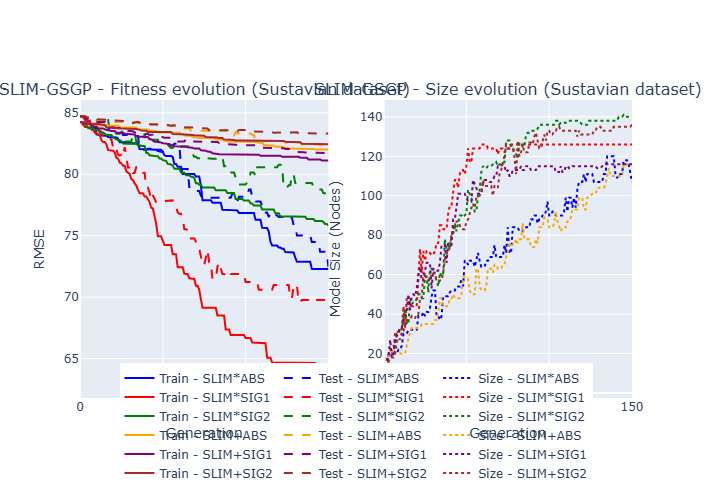

In [85]:
# Group by parameter combo and generation, then calculate median values
median_data = df_log.groupby(['params', 'generation'])[['rmse_train', 'rmse_test', 'number_nodes']].median().reset_index()

# Create subplot figure
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=(
        f'SLIM-GSGP - Fitness evolution ({DATASET_NAME} dataset)',
        f'SLIM-GSGP - Size evolution ({DATASET_NAME} dataset)'
    )
)

colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']


for i, (param_key, group) in enumerate(median_data.groupby('params')):
    color = colors[i % len(colors)]

    # Train RMSE
    fig.add_trace(go.Scatter(
        x=group['generation'],
        y=group['rmse_train'],
        mode='lines',
        name=f'Train - {param_key}',
        line=dict(color=color, dash='solid')
    ), row=1, col=1)

    # Test RMSE
    fig.add_trace(go.Scatter(
        x=group['generation'],
        y=group['rmse_test'],
        mode='lines',
        name=f'Test - {param_key}',
        line=dict(color=color, dash='dash')
    ), row=1, col=1)

    # Size (number of nodes)
    fig.add_trace(go.Scatter(
        x=group['generation'],
        y=group['number_nodes'],
        mode='lines',
        name=f'Size - {param_key}',
        line=dict(color=color, dash='dot')
    ), row=1, col=2)

# Layout settings
fig.update_layout(
    width=1000,
    height=500,
    showlegend=True,
    yaxis_range=[0, None],
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=-0.3,
        xanchor='center',
        x=0.5
    )
)

fig.update_xaxes(title_text='Generation', row=1, col=1)
fig.update_yaxes(title_text='RMSE', row=1, col=1)

fig.update_xaxes(title_text='Generation', row=1, col=2)
fig.update_yaxes(title_text='Model Size (Nodes)', row=1, col=2)

fig.show()

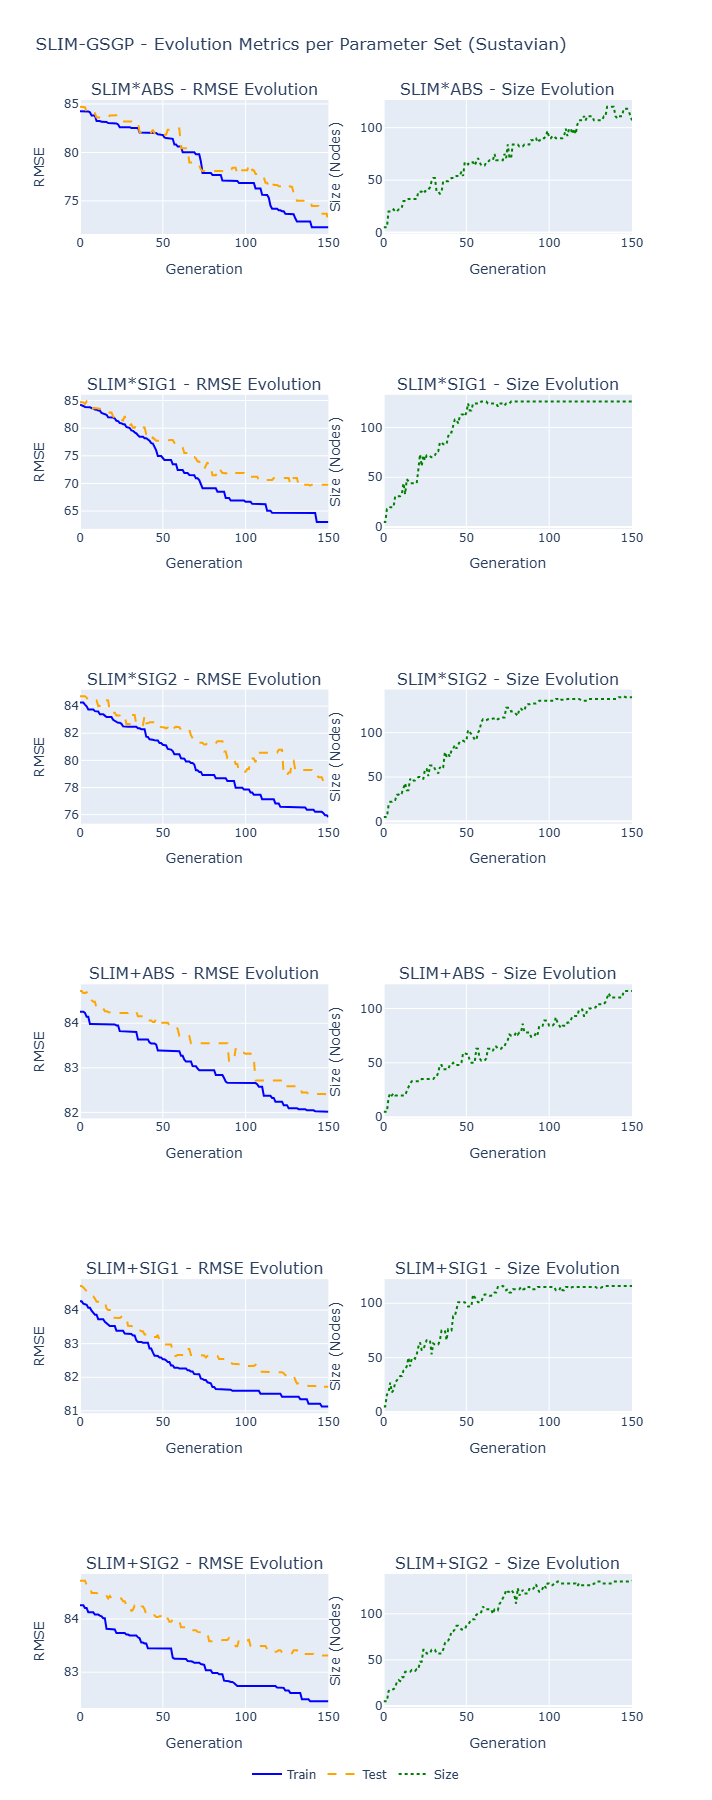

In [77]:

# Group by parameter combo and generation, calculate median values
median_data = df_log.groupby(['params', 'generation'])[['rmse_train', 'rmse_test', 'number_nodes']].median().reset_index()

# Unique parameters
unique_params = median_data['params'].unique()
n_params = len(unique_params)

# Layout: 1 row per parameter, 2 cols (RMSE and Size)
fig = make_subplots(
    rows=n_params, cols=2,
    subplot_titles=[
        f'{param} - RMSE Evolution' if i % 2 == 0 else f'{param} - Size Evolution'
        for param in unique_params for i in range(2)
    ],
    vertical_spacing=0.1
)

for i, param in enumerate(unique_params):
    group = median_data[median_data['params'] == param]

    # Plot RMSE (Train & Test) in column 1
    fig.add_trace(go.Scatter(
        x=group['generation'],
        y=group['rmse_train'],
        mode='lines',
        name='Train',
        line=dict(color=train_color, dash='solid'),
        showlegend=(i == 0)
    ), row=i+1, col=1)

    fig.add_trace(go.Scatter(
        x=group['generation'],
        y=group['rmse_test'],
        mode='lines',
        name='Test',
        line=dict(color=test_color, dash='dash'),
        showlegend=(i == 0)
    ), row=i+1, col=1)

    # Plot Size in column 2
    fig.add_trace(go.Scatter(
        x=group['generation'],
        y=group['number_nodes'],
        mode='lines',
        name='Size',
        line=dict(color=size_color, dash='dot'),
        showlegend=(i == 0)
    ), row=i+1, col=2)

# Layout
fig.update_layout(
    height=300 * n_params,  # adjust height dynamically
    width=1000,
    title_text=f'SLIM-GSGP - Evolution Metrics per Parameter Set ({DATASET_NAME})',
    showlegend=True,
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=-0.05,
        xanchor='center',
        x=0.5
    )
)

# Add axis labels
for row in range(1, n_params + 1):
    fig.update_xaxes(title_text='Generation', row=row, col=1)
    fig.update_xaxes(title_text='Generation', row=row, col=2)
    fig.update_yaxes(title_text='RMSE', row=row, col=1)
    fig.update_yaxes(title_text='Size (Nodes)', row=row, col=2)

fig.show()



Across the evaluated configurations, some SLIM models exhibit an almost perfect inverse relationship between RMSE and tree size: as the tree grows, fitness improves. This indicates that as expected and unlike GP and GSGP, SLIM avoids bloating, where tree size increases without corresponding improvements in fitness. In several SLIM variants, tree size eventually plateaus while fitness continues to improve, suggesting more efficient model structures. However, despite this efficiency, GP and GSGP ultimately achieved better overall fitness on this problem. This means that while SLIM promotes simplicity and controlled growth, it may do so at the cost of solution quality in some cases.

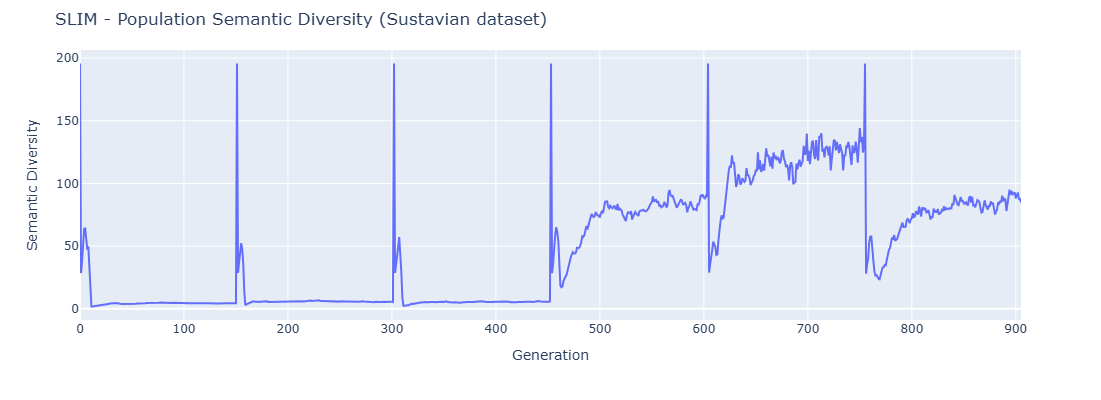

In [74]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=pd.read_csv(LOG_PATH, header=None).iloc[:,10].values, 
                         mode='lines'))
fig.update_layout(
    height=400, width=800, 
    margin=dict(t=50),
    title_text='SLIM - Population Semantic Diversity ('+DATASET_NAME+' dataset)',
    yaxis_range=[0,None],
    xaxis_title='Generation', yaxis_title='Semantic Diversity'
)
fig.show()

The semantic diversity analysis reveals contrasting patterns between SLIM+ (first 452 generation) and SLIM* variants. All models start with high diversity (around 190) due to random initialization. SLIM+ quickly drops to near-zero diversity by generation 6, with minimal recovery (4-5), indicating rapid loss of variability and premature convergence, this confirms that the SLIM+ models are converging prematurely and not exploring the search space effectively. 

In contrast, SLIM* variants recover and maintain higher diversity, with particularly SLIM* SIG1 reaching around 140. This suggests that the SLIM* configurations supports better exploration and aligns with improved training and slightly larger programs. However, a gap between training and test errors suggests this added diversity may not generalize well, risking overfitting.

Overall, these results highlight the importance of balancing semantic diversity with effective control of bloat and overfitting. While SLIM+ prevents bloat successfully, it appears to do so at the cost of population diversity and learning capacity. Meanwhile, SLIM* maintains better diversity and expressiveness but would benefit from additional mechanisms to improve generalization to unseen data.

<a id="subchapter_7_3_4"></a>
#### Fitness Diversity

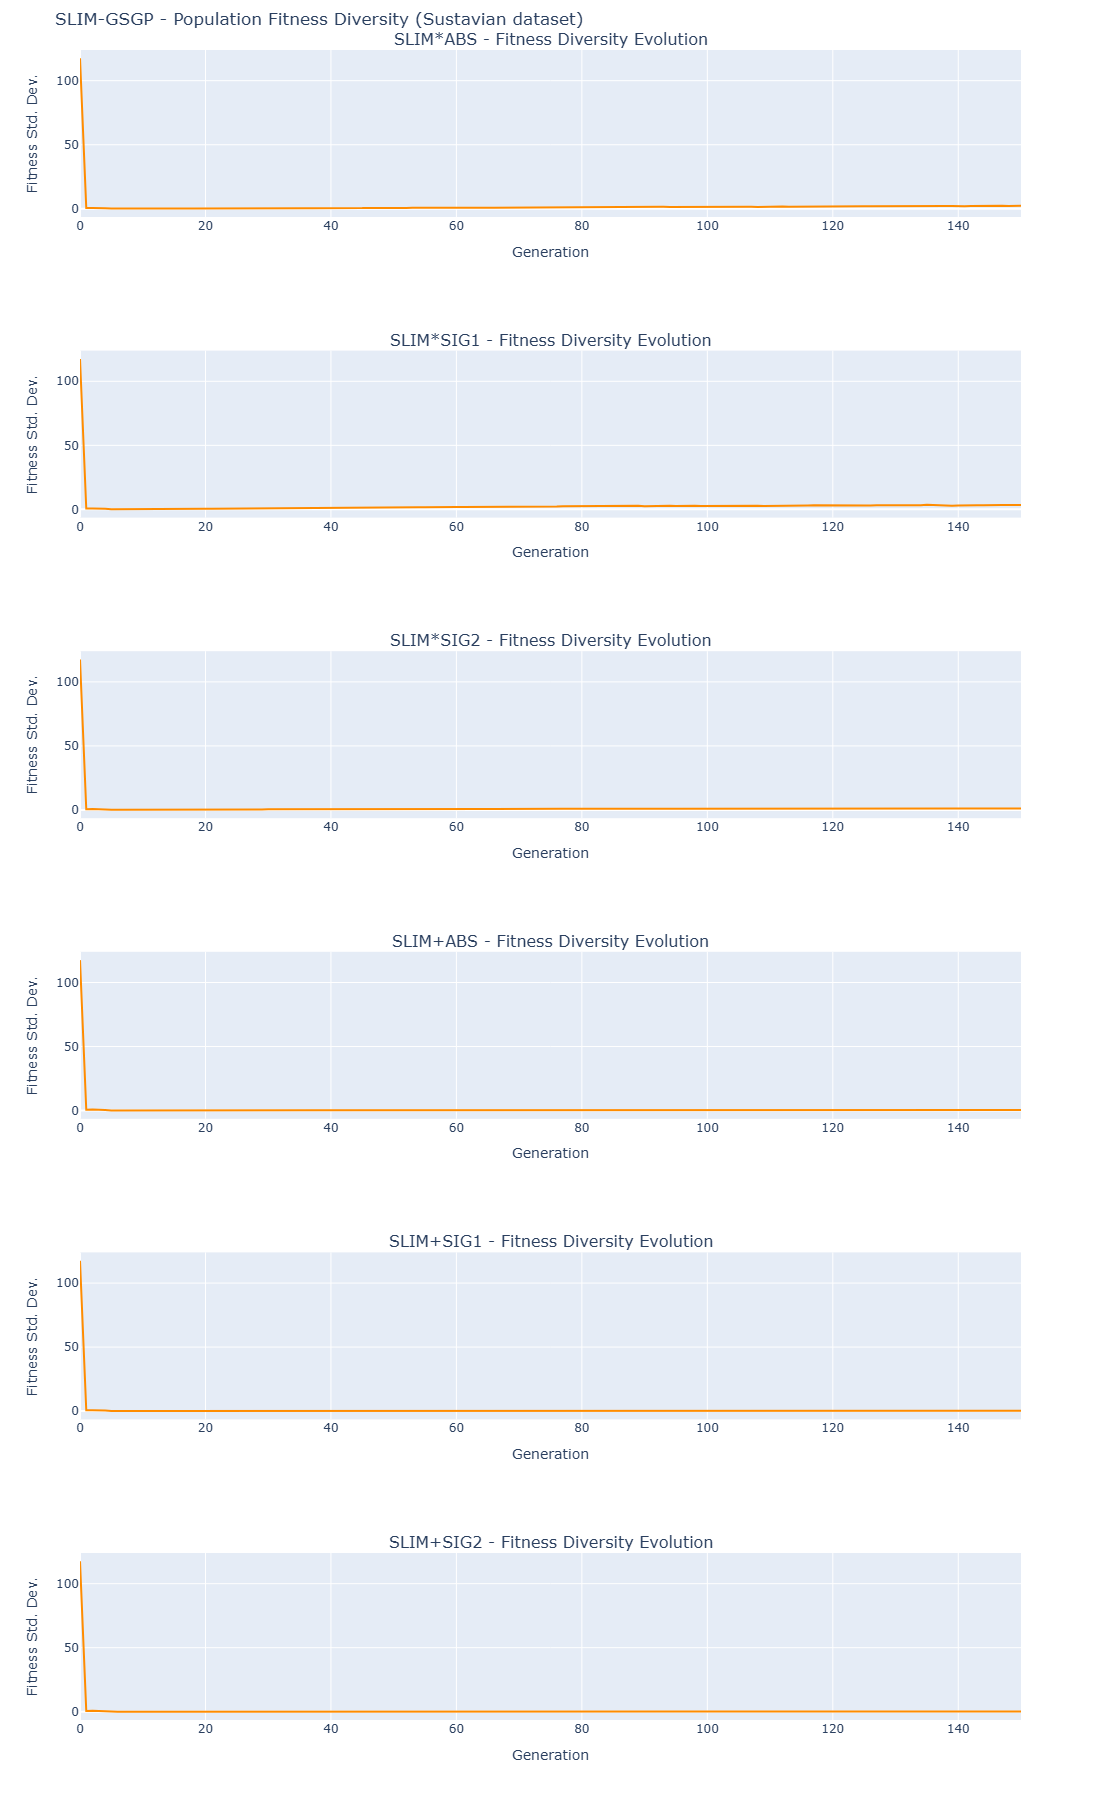

In [75]:


# Compute median fitness diversity per generation and param
fitness_diversity = df_log.groupby(['params', 'generation'])['fitness_std'].median().reset_index()

# Unique parameter sets
unique_params = fitness_diversity['params'].unique()
n_params = len(unique_params)

# Create subplots: 1 row per param
fig = make_subplots(
    rows=n_params, cols=1,
    subplot_titles=[f'{param} - Fitness Diversity Evolution' for param in unique_params],
    vertical_spacing=0.08
)

for i, param in enumerate(unique_params):
    group = fitness_diversity[fitness_diversity['params'] == param]
    
    fig.add_trace(go.Scatter(
        x=group['generation'],
        y=group['fitness_std'],
        mode='lines',
        name=f'{param}',
        line=dict(color='darkorange'),
        showlegend=False
    ), row=i+1, col=1)

# Layout
fig.update_layout(
    height=300 * n_params,
    width=800,
    title_text=f'SLIM-GSGP - Population Fitness Diversity ({DATASET_NAME} dataset)',
    margin=dict(t=50),
    yaxis_range=[0, None]
)

# Axes labels
for row in range(1, n_params + 1):
    fig.update_xaxes(title_text='Generation', row=row, col=1)
    fig.update_yaxes(title_text='Fitness Std. Dev.', row=row, col=1)

fig.show()



The population fitness diversity, measured by the standard deviation of fitness, follows a similar trend to semantic diversity. All variants begin with high fitness variation (around 120), but this drops sharply in the first few generations. SLIM+ variants continue to decline slowly, indicating strong convergence pressure and a lack of exploration, consistent with their stagnant fitness and underfitting behavior.

The SLIM* variants, while also experiencing an initial drop, show a modest recovery in later generations (reaching 2–3). This slight rebound suggests greater diversity in solution quality, supporting better exploration. 

These results further support the idea that SLIM+ converges too quickly, while SLIM* maintains some evolutionary flexibility—though neither fully resolves the balance between exploration, bloat control, and generalization.

#### Summary: 
**Bloat** <br>
SLIM+ variants effectively control bloat, keeping model sizes small throughout. SLIM* allows slightly more growth but remains compact overall. No excessive structural growth observed.

**Overfitting** <br>
SLIM* shows signs of overfitting, with a growing gap between train and test RMSE. SLIM+ avoids overfitting but at the cost of learning capacity.

**Early Convergence** <br>
Both semantic and fitness diversity drop sharply within the first few generations, especially in SLIM+. This indicates early convergence and limited search, leading to underfitting.

**Best Variant**<br>
In the test variants, SLIM*SIG1 was the one with the overall best performance, so is the one that we are going to use as best model

In [86]:
best_model = None
best_rmse = float('inf')

for outer_fold_data in all_results:
    for inner_fold_models in outer_fold_data['results']:
        for model_info in inner_fold_models:
            if model_info['dynamic_params'].get('slim_version') == 'SLIM*SIG1':
                if model_info['rmse_test'] < best_rmse:
                    best_rmse = model_info['rmse_test']
                    best_model = model_info['model']

print(f"Best SLIM*SIG1 test RMSE: {best_rmse}")


Best SLIM*SIG1 test RMSE: 45.22413635253906


In [80]:
y_pred = best_model.predict(X_test)  
y_pred

tensor([32.9733, 54.3483, 60.3951, 36.8467, 30.1443, 41.5290, 77.5285, 19.3023,
        52.3823, 22.7015, 74.3183, 56.3387, 49.7873, 35.3339,  8.2870, 56.5279,
        61.8520, 62.6008, 56.6051])

<a id="chapter_8"></a>
### To Evaluate

We will use these evaluation metrics, MAE, MSE, and correlation coefficients, to measure the performance of each algorithm. After calculating these metrics, we will apply statistical tests to determine whether the observed differences in performance are statistically significant, following the approach recommended by Rainio et al. (2024).


In [81]:
# Converting PyTorch tensors to NumPy arrays

y_true_np = y_test.detach().cpu().numpy()
y_pred_np =  y_pred.detach().cpu().numpy()

In [82]:
# Computing Spearman's rank correlation
spearman_corr_slim, _ = spearmanr(y_true_np, y_pred_np)

print("Spearman’s correlation (rs):", spearman_corr_slim)

Spearman’s correlation (rs): 0.04912280701754386


In [83]:
# Computing MAE and MSE
mae_slim = mean_absolute_error(y_true_np, y_pred_np)
mse_slim = mean_squared_error(y_true_np, y_pred_np)

print("MAE:", mae_slim)
print("MSE:", mse_slim)


MAE: 40.87749481201172
MSE: 1998.419189453125


> As anticipated based on model evaluation, the correlation between predicted and actual values is weak, with high MAE and MSE indicating poor predictive performance